<a href="https://colab.research.google.com/github/Borja-rg/idal_ia3/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón Multi-Capa

En este *Notebook* vamos a implementar un Perceptron Multi-Capa (MLP: *Multilayer Perceptron*) para una tarea de clasificación: 

Para ello, vamos a crear nuestro propio conjunto de datos sintético

**RECUERDA**

En el perceptron multicapa, la salida de cada capa es calculada usando las activaciones de las capas anteriores de la siguiente manera.

$$h_{i} = \sigma(W_i h_{i-1} + b_i)$$

Dónde ${h}_i$ es el vector de activación de la $i$-ésima capa (o los datos de entrada para $i=0$), ${W}_i$ y ${b}_i$ son la matriz de pesos y el vector de sesgo (*bias*) para la capa $i$-ésima respectivamente

<br><rb>
$\sigma(\cdot)$ es la función de activación. En nuestro ejemplo usaremos la función de activación *Sigmoide*, dado que se trata de un problema de clasificación.


## Creación del conjunto de datos sintético
Lo primero que vamos a hacer es crear una función para generar datos sintéticos aletorios. Debes rellenar el siguiente código. Para ello, crea 2 nubes de puntos de 3 dimensiones (una para casa clase). La primera nube (800 puntos) que provenga de una distribución normal con media 0 y desviación estándar 1. La segunda nube de puntos (500 puntos), que sea igual que la primera pero que la última componente tenga media 3 y desviación estándar 0.5. Debes crear un vector de salida con valor 0 para la primera nube de puntos y 1 para la segunda. 

In [57]:
import numpy as np
import sys
import matplotlib.pyplot as plt

def generate_dataset(output_dim=3, num_examples=[800, 500]):
    unos = np.ones(output_dim)
    unos[-1] = 0.5
    ceros = np.zeros(output_dim)
    ceros[-1] = 3
    ax = np.random.randn(num_examples[0],output_dim)
    bx = unos*np.random.randn(num_examples[1],output_dim)+ceros
    x = np.concatenate((ax,bx))
    y = np.concatenate((np.zeros([num_examples[0],1]),np.ones([num_examples[1],1])))
    return (x, y)

Ahora vamos a llamar a la función anterior para generar nuestro conjunto de datos:

In [58]:
np.random.seed(1)
num_examples = [500,800]
output_dim = 3
x, y = generate_dataset(num_examples=num_examples, output_dim=output_dim)


In [59]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

A continuación, representa los datos en 3D, con diferentes colores para representar la pertenencia a cada una de las clases:

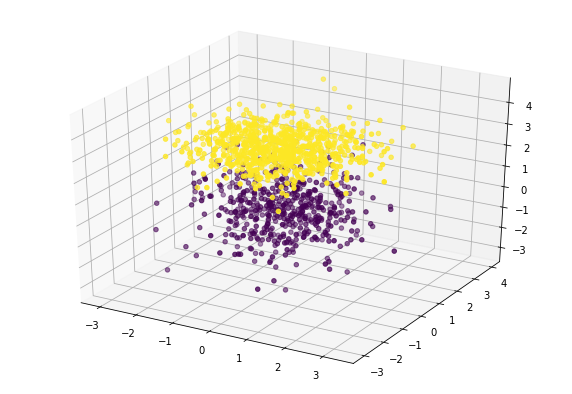

In [6]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=y)

Text(0.5, 0.92, 'simple 3D scatter plot')

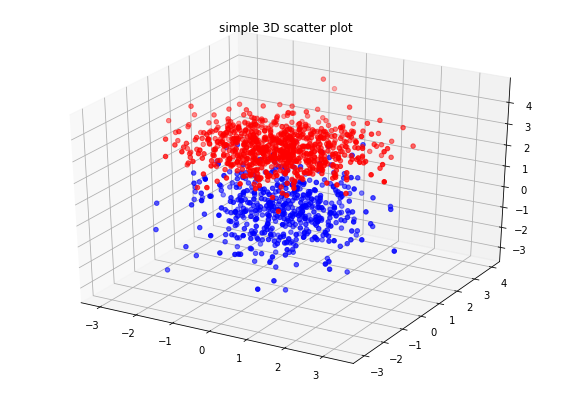

In [7]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
# Creating plot
ax.scatter3D(x[(y == 0).flatten(), 0], x[(y == 0).flatten(), 1], x[(y == 0).flatten(), 2], color="blue")
ax.scatter3D(x[(y == 1).flatten(), 0], x[(y == 1).flatten(), 1], x[(y == 1).flatten(), 2], color="red")
plt.title("simple 3D scatter plot")
# show plot

## Función de activación y su derivada

A continuación vamos a crear dos métodos. El primero implementará la función de activación correspondiente a la sigmoide. Esta función es necesaria para el cáculo *forward pass* de la red.  Dado un valor "x", esta función deberá cacular el varlor con respecto a la siguiente fórmula:
$$a(x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x}}$$

El segundo método, implementará la derivada de la función anterior, necesaria para el *backward pass*. Procediendo con la derivada, obtenemos las siguiente fórmula:

$${a}' = a(1-a)$$



In [8]:
def sigmoid(x):
  sig = 1/(1+np.e**(-x))
  return sig

In [9]:
def sigmoid_out2deriv(out):
  deriv_sig = out*(1-out)
  return deriv_sig

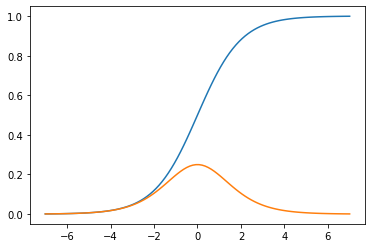

In [16]:
points = np.linspace(-7,7,100)
plt.plot(points,sigmoid(points))
plt.plot(points,sigmoid_out2deriv(sigmoid(points)))

## Contruyendo la Red Neuronal Artificial
A continuación vamos a definir la clase Layer. Ésta implementará los 3 métodos necesarios para entrenar la red neuronal (*forward*, *backward* y *update*). Recuerda que el `__init__` debe generar los pesos ${W}$ y ${b}$  de manera aleatoria. Para ello, utiliza una distribución normal con media -0.1 y desviación estándar 0.2.

<br><rb>
Para el cáculo del *backward pass* hay que calcular las derivadas parciales del coste (error) con respecto a cada uno de los parámetros de la red (${W}$ y ${b}$). Para ello, en esta clase solamente vamos a declarar las derivadas de las capas intermedias (las derivadas parciales de la última capa, que se calculan de manera distinta, las calcularemos fuera de esta clase. Los $\delta$ de los ${W}$ se calculan en función de los $\delta$ de la capa anterior:

$$ \delta^{l-1} = W^{l}\delta^{l}\frac{\partial a^{l-1}}{\partial z^{l-1}}$$

Donde $a$ es la función de activación, $z$ es la salida de la suma ponderada de la entrada (la salida de la neurona, la regresión lineal, antes de aplicar la función de activación) y $l-1$ hace referencia a la "*Layer*" anterior.

<br><rb>
 De ahí, que el método `backward` tenga compo parámetro de entrad la variable `output_delta` (correspondiente a los $\delta$ de la capa anterior). Para el cálculo de $\delta$ de los parámetros ${W}$ la capa actual hemos de realizar dos operaciones. La primera es multiplicar el $\delta$ de la capa posterior (que proviene del parámetro de entrada `output_delta`) por la derivada de la función de activación aplicada sobre la salida de la red en el *forward pass*. La segunda operación es el producto del resultado anterior por los pesos ${W}$.

<br><rb>
Para actualizar la red (método `update`) deberemos actualizar los pesos ${W}$ con un nuevo valor de la siguiente manera:
$$W_{i}(t)\:=\:W_{i}(t-1) - \alpha(\frac{\partial error}{\partial W_{i}})$$

Siendo $(\frac{\partial error}{\partial W_{i}})$ la derivada de la función de activación aplicada sobre la salida de la red en el forward pass (calculada en el método `backward`).


In [66]:
class Layer(object):
    def __init__(self, input_dim, output_dim, activation_func, act_func_deriv):
      self.weights = 0.2*np.random.randn(input_dim,output_dim)-0.1
      self.bias = 0.2*np.random.randn(1,output_dim)-0.1
      self.activation_func = activation_func
      self.act_func_deriv = act_func_deriv

    def forward(self, input):
      self.input = input
      self.output = self.activation_func(np.dot(self.input,self.weights)+self.bias)
      return self.output

    def backward(self, output_delta):
      self.weight_output_delta = output_delta*self.act_func_deriv(self.output)
      new_delta = np.dot(self.weight_output_delta,self.weights.T)
      return new_delta

    def update(self, learning_rate=0.1):
      self.weights-=learning_rate*np.dot(self.input.T,self.weight_output_delta) 


## Entrenamiento de la Red

Inicializamos  los siguientes parámetros:


In [19]:
batch_size = 10
learning_rate = 0.1

input_dim = len(x[0])
layer_1_dim = 128
layer_2_dim = 64
output_dim = 1
iterations = 1000

In [20]:
len(x[0])

3

Creamos nuestra red neuronal de 3 capas llamando a la clase `Layer` tantas veces como sea necesario:


In [67]:
layer_1 = Layer(input_dim,layer_1_dim,sigmoid,sigmoid_out2deriv)
layer_2 = Layer(layer_1_dim,layer_2_dim,sigmoid,sigmoid_out2deriv)
layer_3 = Layer(layer_2_dim,output_dim,sigmoid,sigmoid_out2deriv)

A continuación procederemos a entrenar nuestra red. Para ello necesitaremos crear *batches* de nuestro conjunto de datos para ir pasándoselos a la red por lotes. Para ello necesitaremos 2 bucles `for`. El primero iterará sobre un número de iteraciones (épocas), y el segundo sobre los *batches*. Se pasará cada *batch* a la red para hacer el *forward pass* y calcular la salida de la red. Después, haremos el *backward pass* (en order inverso) para actualizar los pesos de la red. Recuerda, que en la implementación de la clase `Layer`solamente se implemetó el *backward pass* de las capas intermedias. Por lo tanto, es necesario que prinero calcules el $\delta$ de la última capa para pasárselo al método `Layer.backward()`. Dicho $\delta$ es igual a la diferencia entre la salida de la red y la salida real. Finalmente actualiza cada capa con el método `Layer.update()` y computa el error acumulado por cada batch en cada época. Imprime el error cada 10 épocas por pantalla.

In [69]:
for iter in range(iterations):
  error = 0
  for batch_i in range(int(len(x)/batch_size)):
    batch_x = x[batch_size * batch_i:batch_size*(batch_i+1)]
    batch_y = y[batch_size * batch_i:batch_size*(batch_i+1)]

    layer_1_out = layer_1.forward(batch_x)
    layer_2_out = layer_2.forward(layer_1_out)
    layer_3_out = layer_3.forward(layer_2_out)

    layer_3_del = layer_3_out - batch_y
    layer_2_del = layer_3.backward(layer_3_del)
    layer_1_del = layer_2.backward(layer_2_del)
    layer_1.backward(layer_1_del)

    layer_1.update()
    layer_2.update()
    layer_3.update()
      
    error += (np.sum(layer_3_del**2))/len(layer_3_del)
    
  sys.stdout.write("\rIter:" + str(iter) + " Loss:" + str(error))
  if iter % 10 == 0:
    print("")

Iter:0 Loss:56.14539299463786
Iter:10 Loss:3.8500255244517856
Iter:20 Loss:3.3755042581158508
Iter:30 Loss:3.3876937992160827
Iter:40 Loss:3.634124169547923
Iter:50 Loss:3.815197389345698
Iter:60 Loss:3.932404005720526
Iter:70 Loss:4.0058312047107885
Iter:80 Loss:4.003806894495839
Iter:90 Loss:3.9510171654080204
Iter:100 Loss:3.928149971152827
Iter:110 Loss:3.9605768747749712
Iter:120 Loss:4.023493841231097
Iter:130 Loss:4.108954713035507
Iter:140 Loss:4.2145173069753366
Iter:150 Loss:4.319501386454745
Iter:160 Loss:4.394919685648715
Iter:170 Loss:4.444286520838825
Iter:180 Loss:4.479464970974068
Iter:190 Loss:4.511127860097167
Iter:200 Loss:4.545997623291726
Iter:210 Loss:4.587684554340541
Iter:220 Loss:4.633445383031188
Iter:230 Loss:4.616401036106586
Iter:240 Loss:4.566598627772908
Iter:250 Loss:4.54787728667367
Iter:260 Loss:4.537680488767466
Iter:270 Loss:4.528305138834231
Iter:280 Loss:4.5169133094798335
Iter:290 Loss:4.504954221716455
Iter:300 Loss:4.4954069591725565
Iter:310 Lo